# Setup

In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports

import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from utils import get_wiki_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"

In [3]:
# Load GPT2 model fine-tuned on writing prompts

gpt2_modelfile = 'gpt2-xl'
model_args = ModelArguments(
    model_name_or_path=gpt2_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')

In [4]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [5]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [23]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/greedy.jsonl"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5.jsonl"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_p_0.9.jsonl"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_k_30.jsonl"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/typical_p_0.9.jsonl"
gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5_eab.jsonl"
gpt2_eags_v1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v1_k_30.jsonl"
gpt2_eags_v2_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v2_k_30.jsonl"
gpt2_eags_v3_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v3_k_30.jsonl"

In [7]:
NUM_SEQ=1000
MAX_LEN = 128
WIDTH = 5

# Entropy of Human Data

In [8]:
human_dataframe = pd.read_json(orig_wp, lines=True)\
                        .rename(columns={'prefix':'context', 
                                         'target': 'model_text'})

In [9]:
human_datapoint = human_dataframe.sample().iloc[0]
print(human_datapoint.context)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

B of the Bang was a sculpture by Thomas Heatherwick next to the City of Manchester Stadium in Manchester, England, United Kingdom, which was commissioned to mark the 2002 Commonwealth Games; it was one of the tallest structures in Manchester and the tallest sculpture in the UK until the completion of Aspire in 2008. It was taller and leaned at a greater angle than the Leaning Tower of Pisa. The sculpture took its name from a quotation of British sprinter Linford Christie, in which he said that he started his races not merely at the "bang" of the starting pistol, but at "the B of the Bang". The sculpture was commissioned in 2003; construction overran and the official unveiling was delayed until 12 January 2005. Six days before the launch, the sculpture suffered the first of three visible structural problems as the tip of one of the spikes detached and fell to the ground.

Legal action started a year later, resulting in an out-of-court settlement totalling £1.7 million. In February 2009,

## Compute Average entropy across sequences.

In [11]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

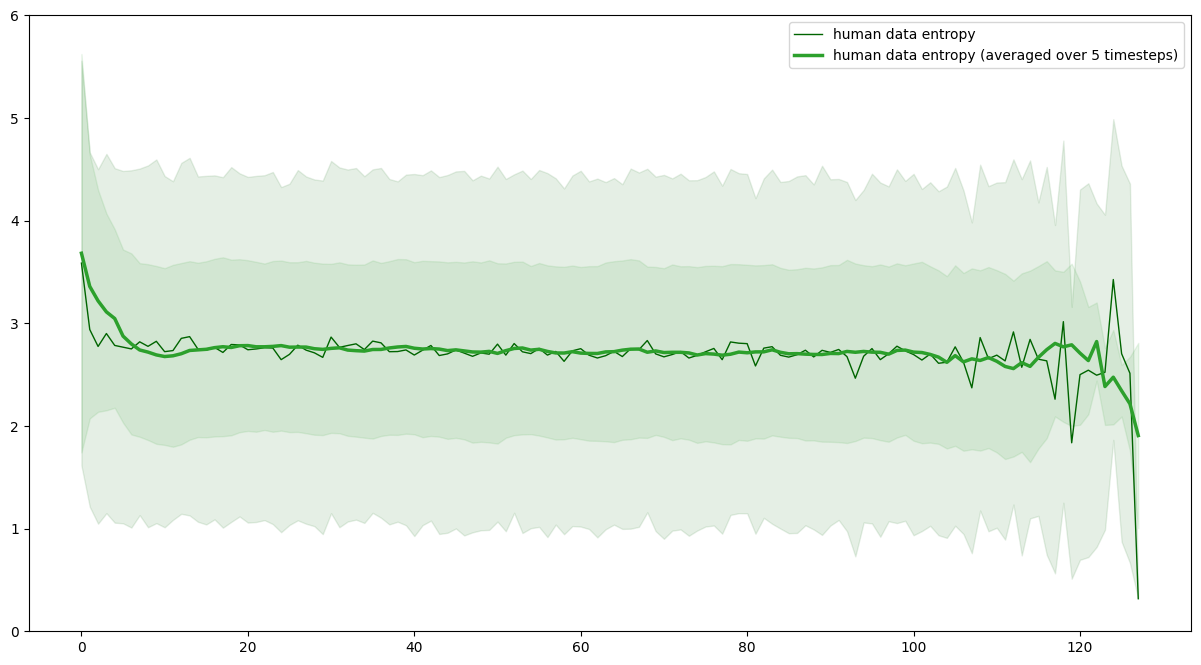

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [13]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


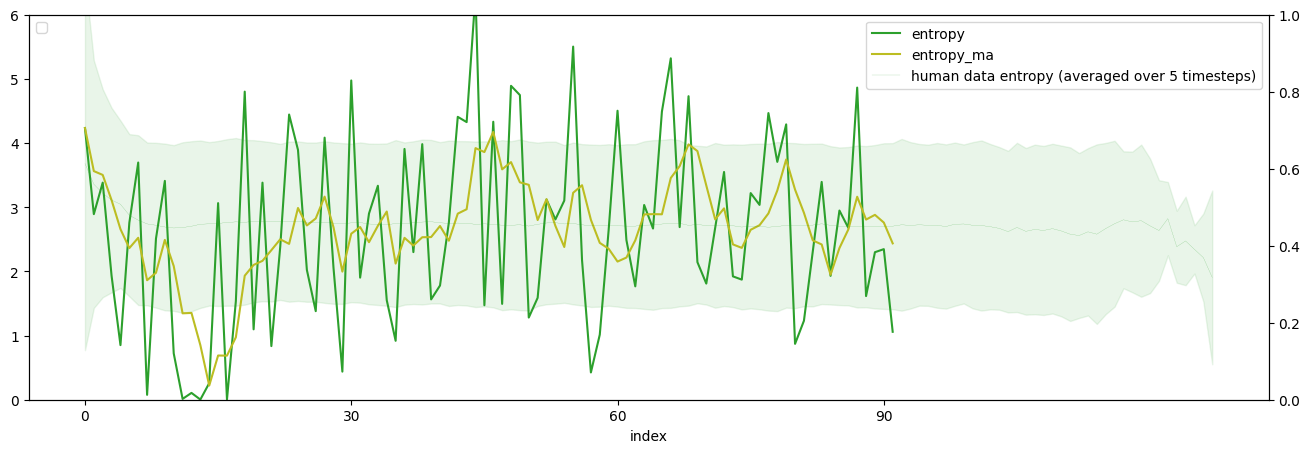

In [14]:
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy', ylim=(0,5), ax=ax, color='tab:green')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:olive')

ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


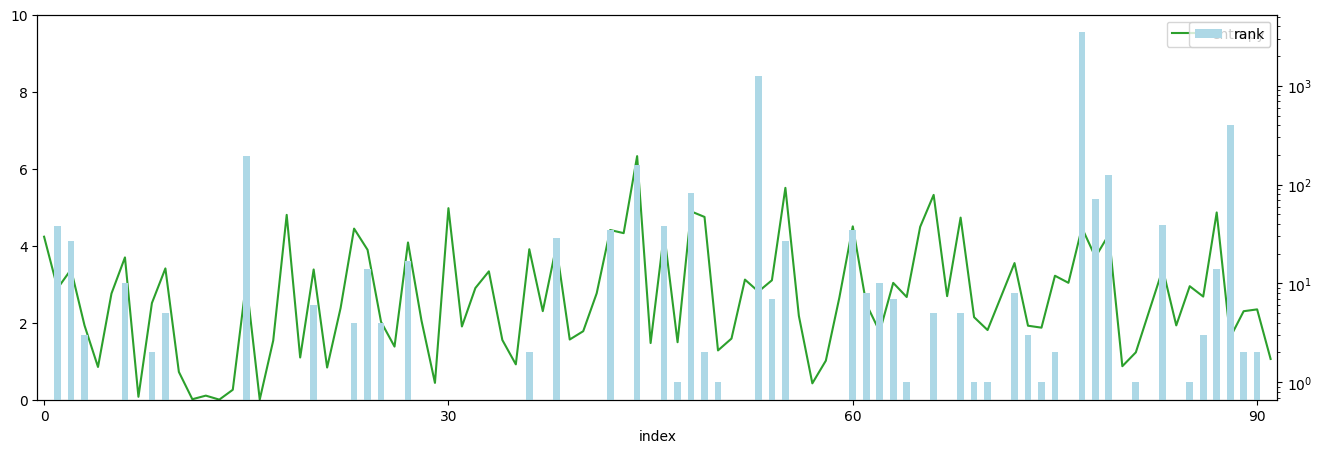

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2 = ax.twinx()
ax2.legend(loc=2)
ax2.set_yscale('log')

lpdh.plot.bar(x="index", y='rank', ax=ax2, color='lightblue', )
lpdh.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')

ax.set_xticks(np.arange(len(lpdh['index']), step=30))



# Entropy of Model Data

In [24]:
model_greedy_dataframe = pd.read_json(gpt2_greedy_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
model_greedy_dataframe.dropna(inplace=True)

model_beam_dataframe = pd.read_json(gpt2_beam_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_nucleus_dataframe = pd.read_json(gpt2_nucleus_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_topk_dataframe = pd.read_json(gpt2_topk_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_typical_dataframe = pd.read_json(gpt2_typical_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_eags_v1_dataframe = pd.read_json(gpt2_eags_v1_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_eags_v2_dataframe = pd.read_json(gpt2_eags_v2_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
                                                 
model_eags_v3_dataframe = pd.read_json(gpt2_eags_v3_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
# model_eabs_dataframe = pd.read_csv(gpt2_entropy_beam_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])


In [109]:
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

print(human_datapoint_idx)

human_datapoint_idx=34

32


In [110]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe[model_greedy_dataframe.context == human_datapoint.context].iloc[0]
beam_sample = model_beam_dataframe[model_beam_dataframe.context == human_datapoint.context].iloc[0]
nucleus_sample = model_nucleus_dataframe[model_nucleus_dataframe.context == human_datapoint.context].iloc[0]
topk_sample = model_topk_dataframe[model_topk_dataframe.context == human_datapoint.context].iloc[0]
typical_sample = model_typical_dataframe[model_typical_dataframe.context == human_datapoint.context].iloc[0]
eag_v1_sample = model_eags_v1_dataframe.iloc[human_datapoint_idx]
eag_v2_sample = model_eags_v2_dataframe.iloc[human_datapoint_idx]
eag_v3_sample = model_eags_v3_dataframe.iloc[human_datapoint_idx]

# eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx * 10]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text)
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text)
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text)
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text)
print()

print("EAG Model V1 Text:")
print_sample(human_datapoint.context, eag_v1_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAG Model V2 Text:")
print_sample(human_datapoint.context, eag_v2_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAG Model V3 Text:")
print_sample(human_datapoint.context, eag_v3_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

# print("EABS Model Text:")
# print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eabs_sample.voilations}")
# print()

Context:
The route intersects CR 637, turning to the northeast. After passing some homes and Stephen Lake, the road turns to the north and passes to the west of Estell Manor County Park. The route crosses the South River into Weymouth Township, passing the residential community of Belcoville to the east and meeting CR 669. It soon enters Hamilton Township, where the name of the road becomes Mill Street and it comes to a junction with US 40 (Harding Highway). CR 557 Truck heads to the west on US 40 at this point while Route 50 heads east on US 40, and CR 616 continues north. US 40 and Route 50 follow the Harding Highway, a two-lane undivided road, turning to the northeast and crossing the Great Egg Harbor River. Upon passing over the river, enters Mays Landing and turns north, encountering CR 617 before passing over an abandoned railroad line and heading into the downtown area of Mays Landing.

Target:
Here, the road crosses CR 559, and US 40 splits from Route 50 by turning east along t

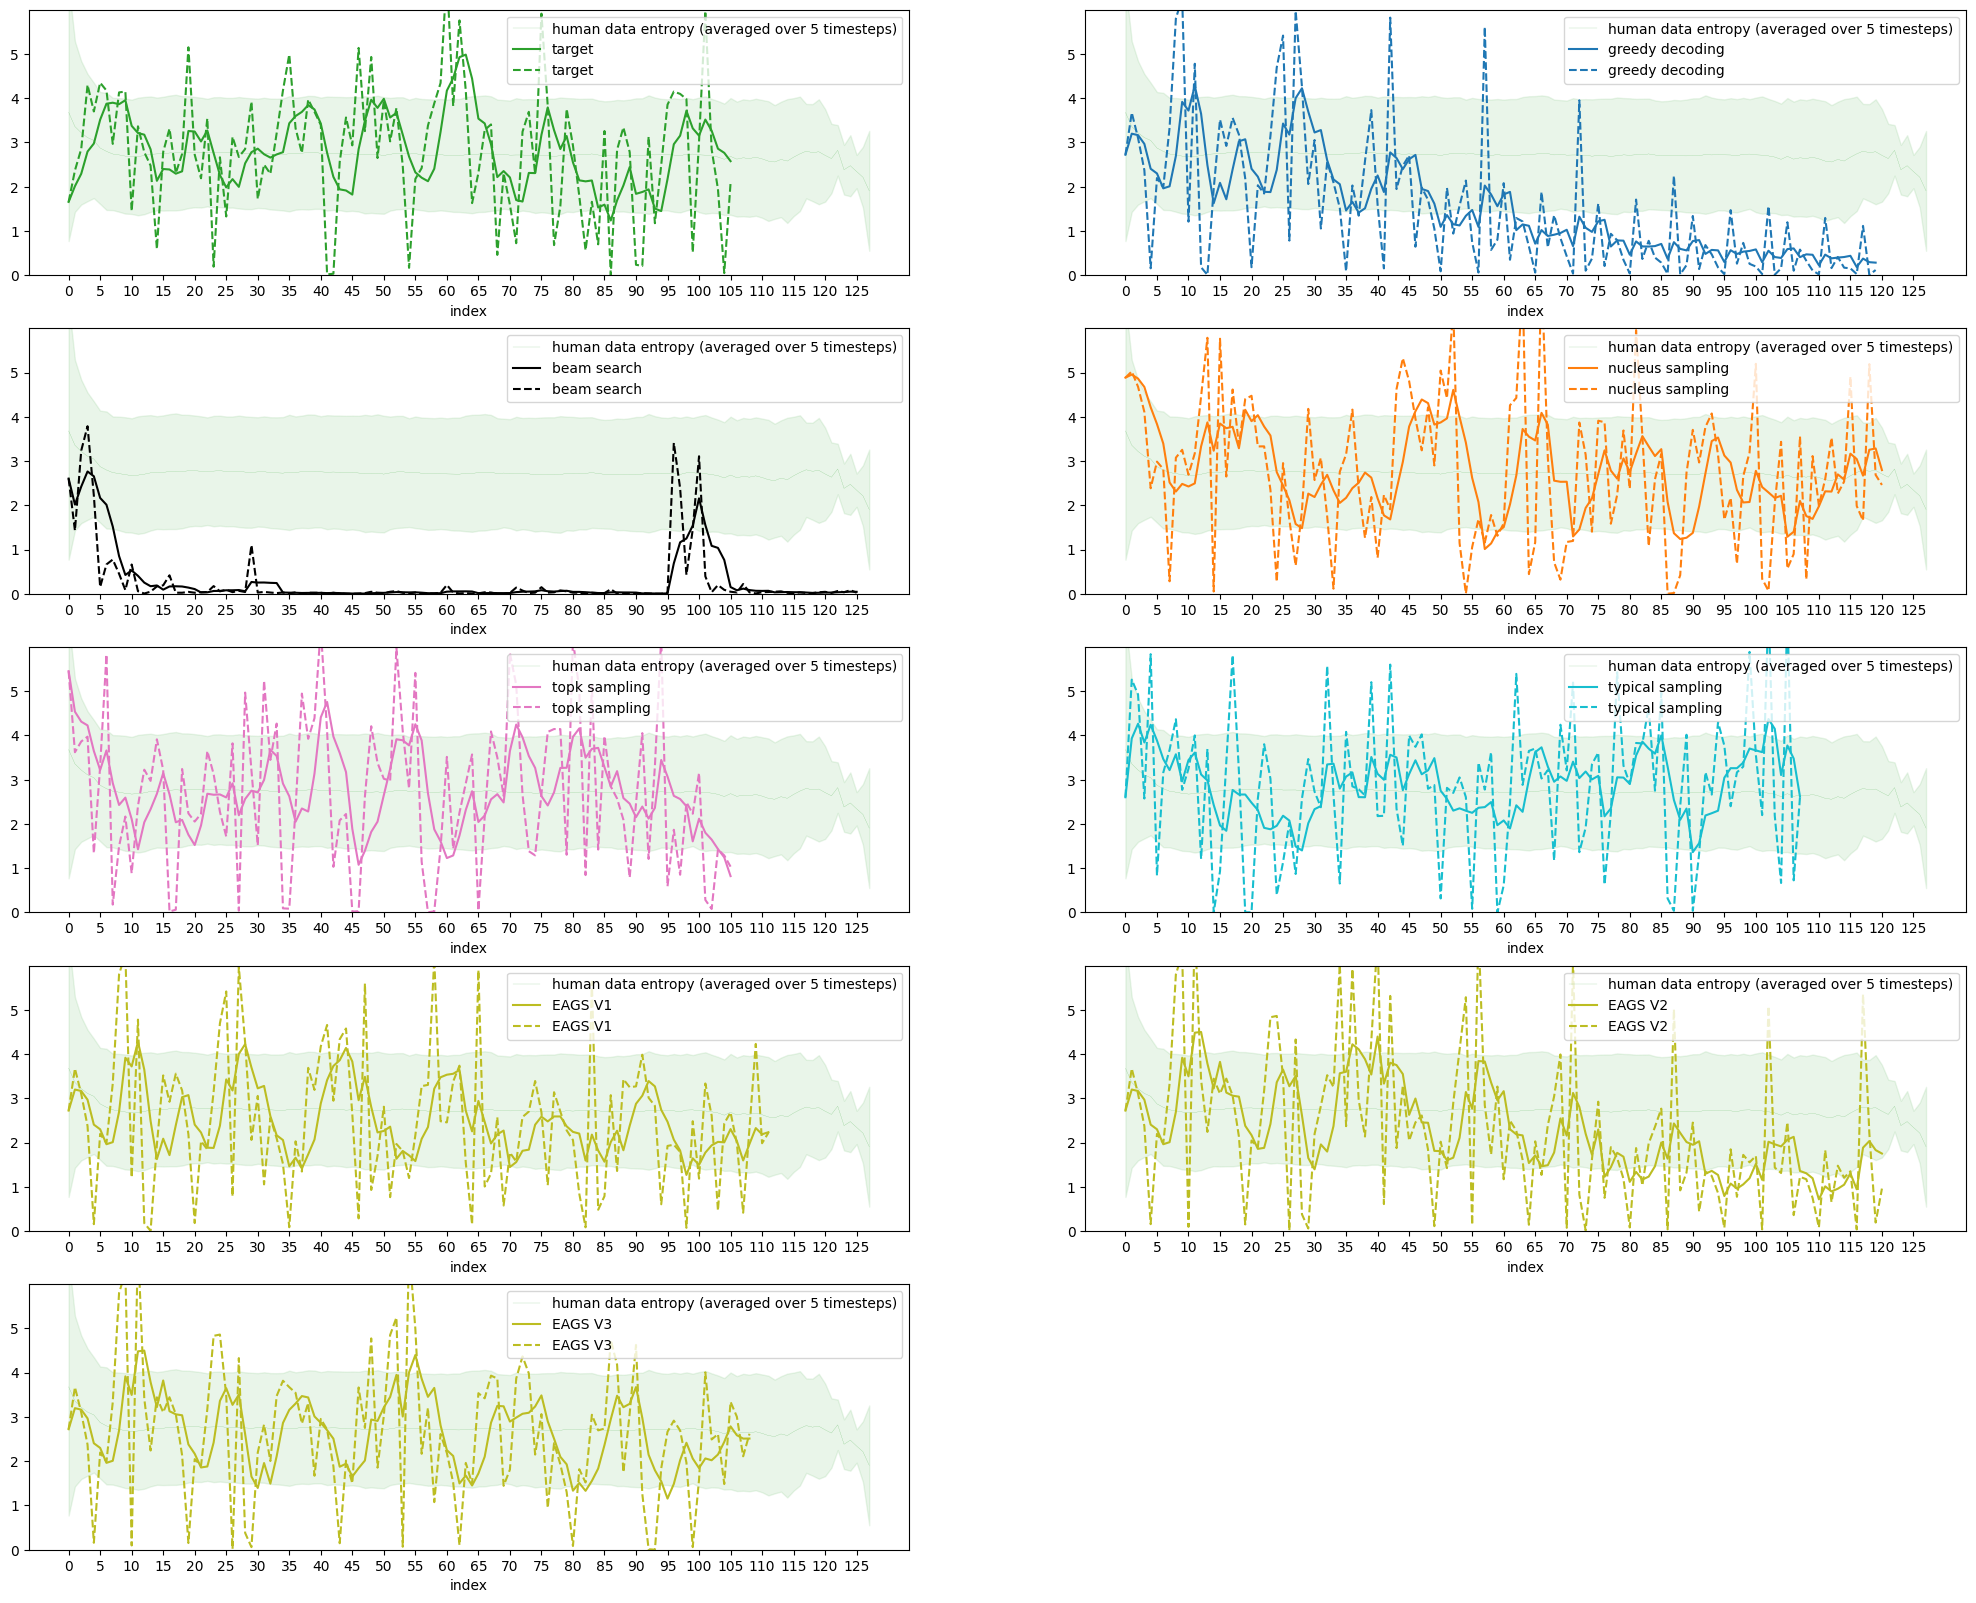

In [115]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

eag_v1_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=eag_v1_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

eag_v2_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

eag_v3_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(5,2, figsize=(25, 20))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
lpdh.plot(x="index", y='entropy', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 0], label='beam search', color='black')
beam_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[1, 0], label='beam search', color='black', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling', color='tab:orange')
nucleus_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling', color='tab:orange', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,0], label='topk sampling', color='tab:pink')
topk_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[2,0], label='topk sampling', color='tab:pink', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,1], label='typical sampling', color='tab:cyan')
typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[2,1], label='typical sampling', color='tab:cyan', linestyle='dashed')


plot_avg_entropies_mean_std(human_ma_entropies, axs[3,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
eag_v1_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 0], label='EAGS V1', color='tab:olive')
eag_v1_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[3, 0], label='EAGS V1', color='tab:olive', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[3,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
eag_v2_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 1], label='EAGS V2', color='tab:olive')
eag_v2_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[3, 1], label='EAGS V2', color='tab:olive', linestyle='dashed')

plot_avg_entropies_mean_std(human_ma_entropies, axs[4,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
eag_v3_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[4, 0], label='EAGS V3', color='tab:olive')
eag_v3_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[4, 0], label='EAGS V3', color='tab:olive', linestyle='dashed')

plt.setp(axs, xticks=range(0, MAX_LEN, 5),
            yticks=range(0,6))

fig.delaxes(axs[4,1])
# # ax.set_xticklabels(lpdm['token'])
# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

In [112]:
' '.join(eag_v3_labeled_datapoint.token[5:10])

'Ġthe Ġsouth Ġand Ġenters Ġthe'

In [113]:
[(i, x,y) for (i, (x, y)) in enumerate(zip(eag_v3_labeled_datapoint.token[0:90], eag_v3_labeled_datapoint.entropy[0:90]))]

[(0, 'The', 2.7234978675842285),
 (1, 'Ġroute', 3.6740736961364746),
 (2, 'Ġthen', 3.1002514362335205),
 (3, 'Ġturns', 2.374711275100708),
 (4, 'Ġto', 0.1568395048379898),
 (5, 'Ġthe', 2.1964173316955566),
 (6, 'Ġsouth', 1.9874475002288818),
 (7, 'Ġand', 3.333817481994629),
 (8, 'Ġenters', 5.800694942474365),
 (9, 'Ġthe', 6.269888401031494),
 (10, 'Ġcommunity', 0.09617286920547485),
 (11, 'Ġof', 6.917781352996826),
 (12, 'ĠLong', 3.413961172103882),
 (13, 'ĠBeach', 2.2418646812438965),
 (14, '.', 3.4439072608947754),
 (15, 'ĠThe', 3.1043410301208496),
 (16, 'Ġroute', 3.4454879760742188),
 (17, 'Ġthen', 3.0634171962738037),
 (18, 'Ġturns', 2.1339855194091797),
 (19, 'Ġto', 0.151187002658844),
 (20, 'Ġthe', 2.0468616485595703),
 (21, 'Ġeast', 1.8972538709640503),
 (22, 'Ġand', 3.1754026412963867),
 (23, 'Ġenters', 4.832868576049805),
 (24, 'Ġthe', 4.862323760986328),
 (25, 'Ġsouthern', 3.481771945953369),
 (26, 'Ġpart', 0.01498425006866455),
 (27, 'Ġof', 4.330175399780273),
 (28, 'ĠM', 0

In [116]:
greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

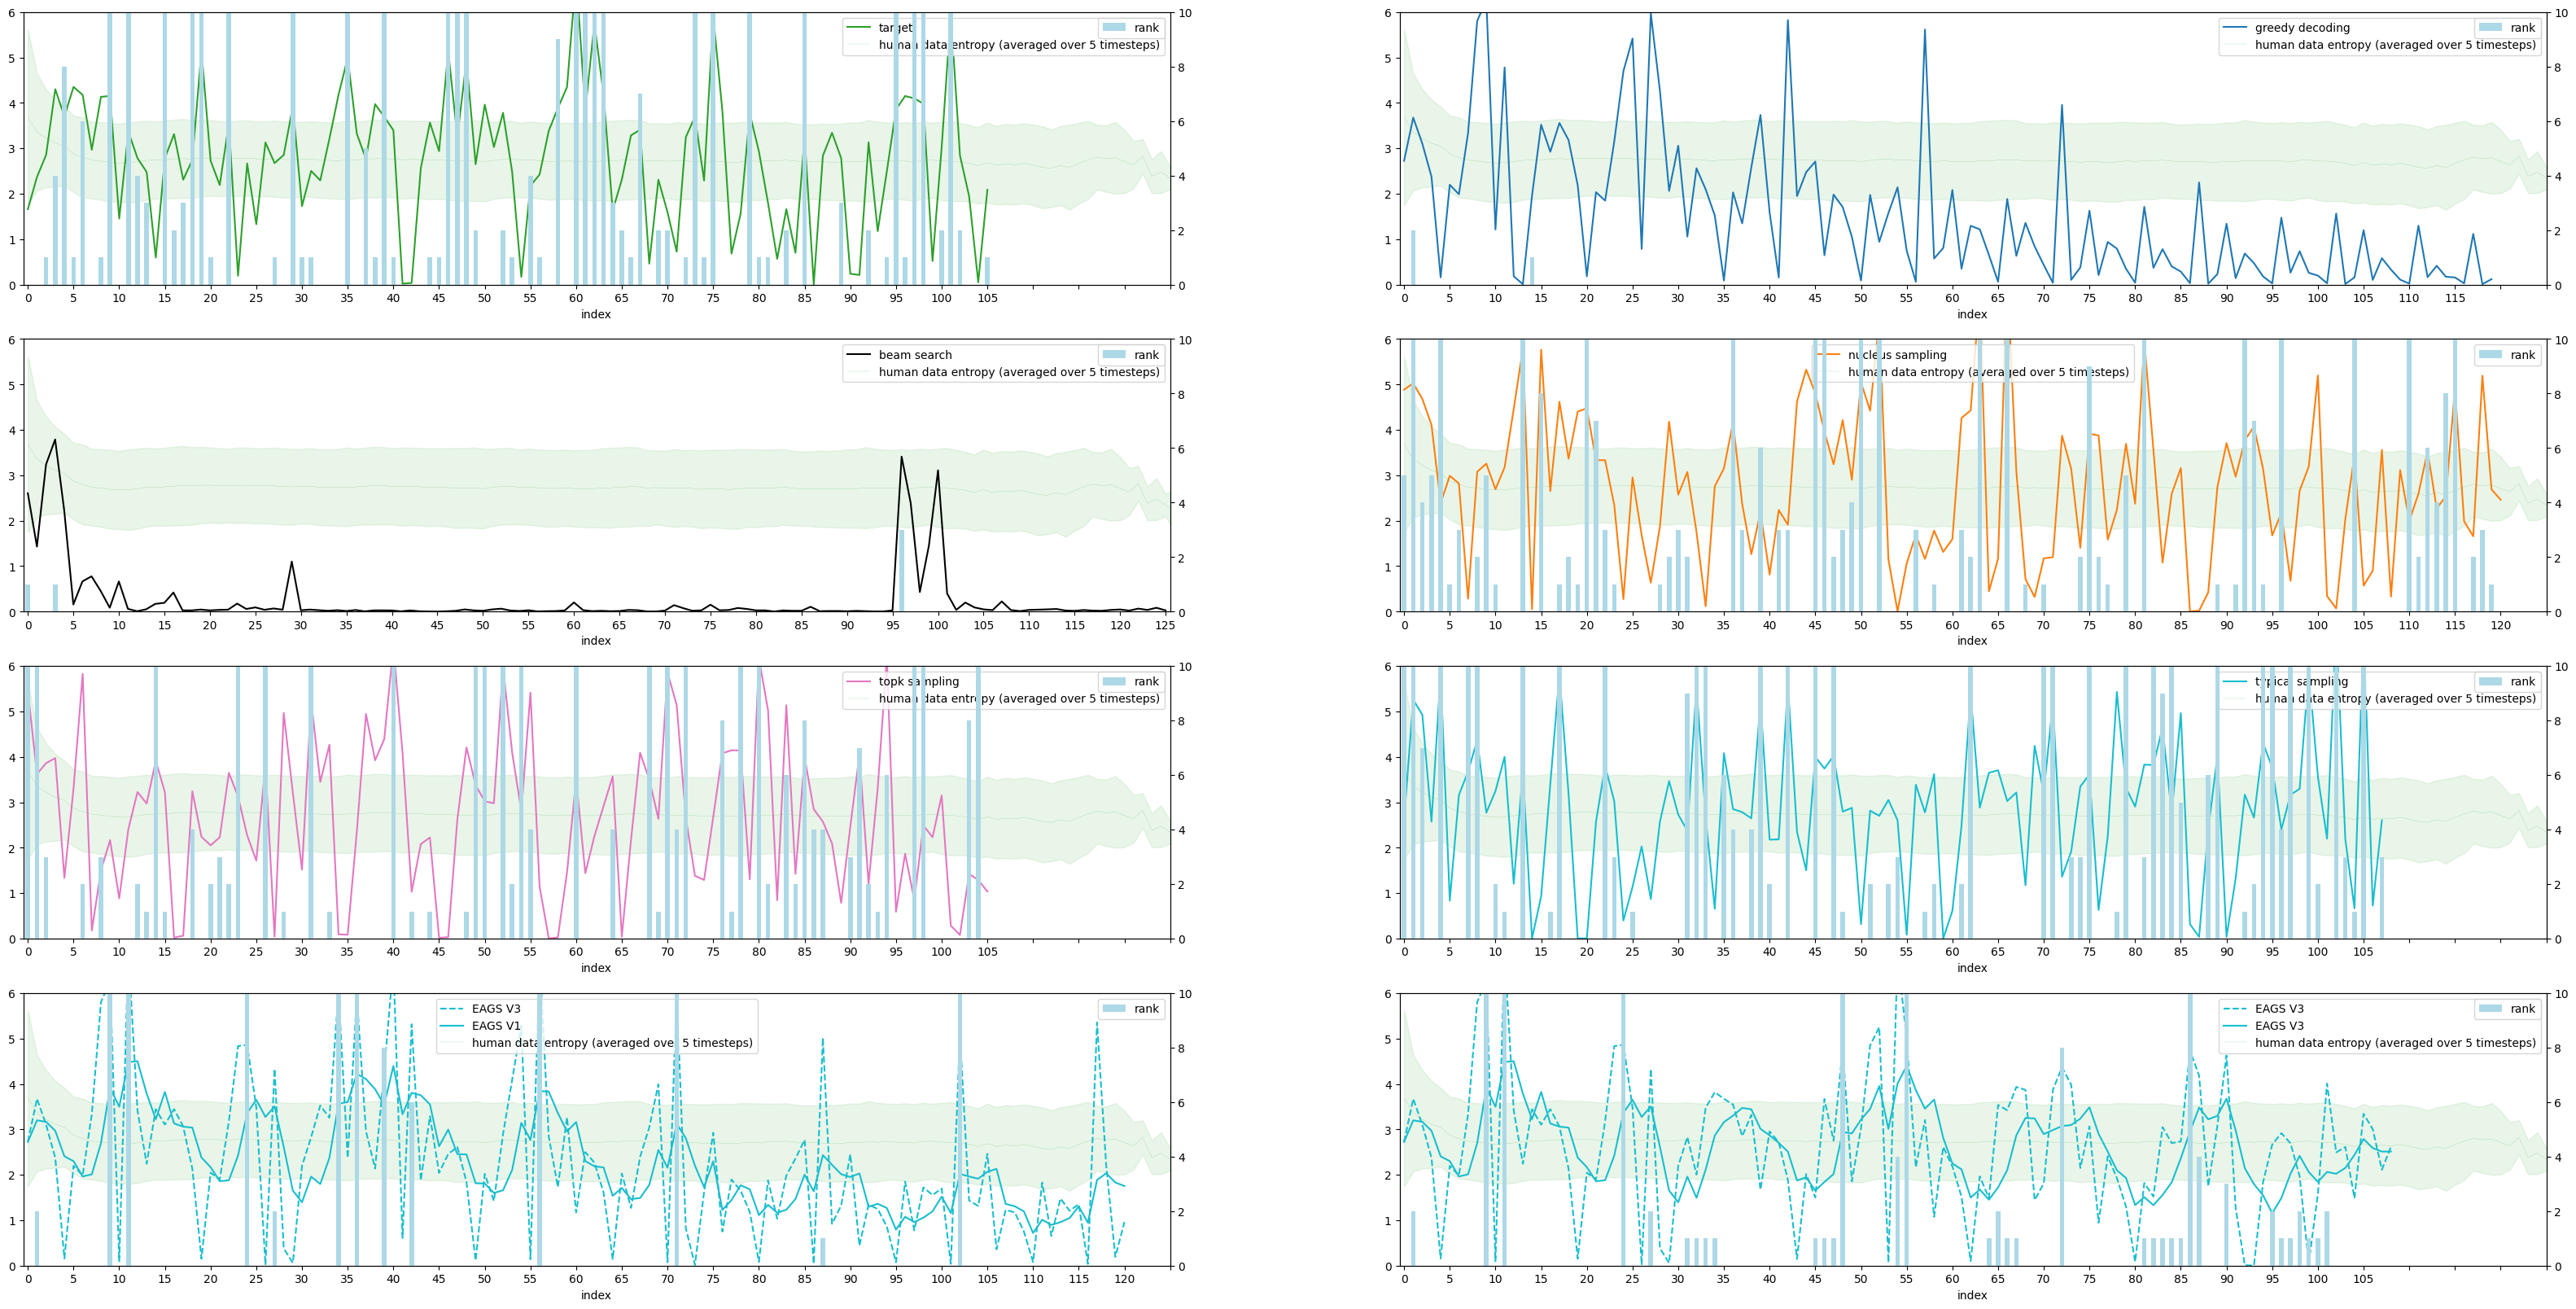

In [119]:
fig, axs = plt.subplots(4,2, figsize=(40, 20))
# plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0,0], label='target', color='tab:green')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)

ax2 = axs[0,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
lpdh.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[0,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
greedy_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

beam_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 0], label='beam search', color='black')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
beam_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

nucleus_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 1], label='nucleus sampling', color='tab:orange')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
nucleus_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

topk_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,0], label='topk sampling', color='tab:pink')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
topk_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,1], label='typical sampling', color='tab:cyan')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
typical_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

eag_v2_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan', linestyle='dashed')
eag_v2_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan')
plot_avg_entropies_mean_std(human_ma_entropies, axs[3,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[3,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
eag_v2_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


eag_v3_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan', linestyle='dashed')
eag_v3_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan')

plot_avg_entropies_mean_std(human_ma_entropies, axs[3,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[3,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
eag_v3_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

plt.setp(axs, xticks=range(0, MAX_LEN, 5))


## Generate using Entropy Aware Greedy Search

In [ ]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [ ]:
# Greedy
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

In [ ]:
# Beam
model_gen_beam_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_beam_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

In [ ]:
# Nucleus
model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Topk
model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Typical Decoding
model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps'}, xlabel='Timesteps', ylabel='Average Entropy'>

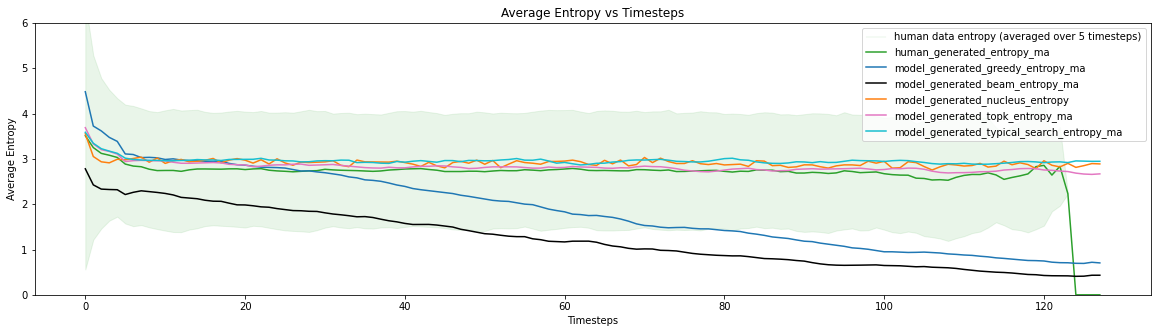

In [ ]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd,  model_gen_beam_avg_ma_entropy_pd, model_gen_nucleus_avg_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(20, 5))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Analysis to discover entropy awareness criteria

In [78]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

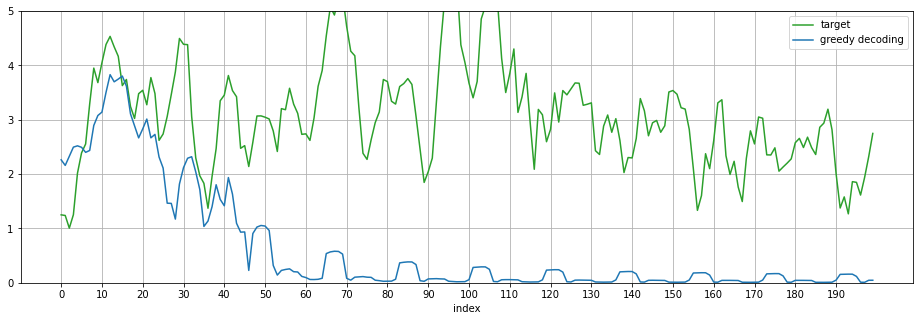

In [79]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [80]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")